In [15]:
from src.models.train_model import premis_model
from src.data.preprocessing import load_thickness_time_series
import numpy as np
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from datetime import datetime, timedelta
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    rem = decimal_year - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds = (base.replace(year = base.year + 1) - base).total_seconds() * rem)
    result = datetime.date(result)
    return result

(920.0, 950.0)

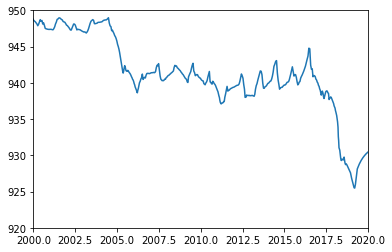

In [13]:
mat = loadmat('../1900_2020_mean_thickness.mat')
thickness = mat['thickness'].squeeze()
time = mat['time'].squeeze()
plt.plot(time, thickness)
plt.xlim([2000, 2020])
plt.ylim([920, 950])

In [39]:
df = load_thickness_time_series('../1900_2020_mean_thickness.mat')

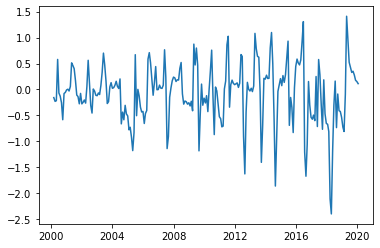

In [47]:
plt.plot(df.Time[1200:], df.Thickness[1200:])

In [13]:
#y_tmp = premis_model(m, x=1, n=128, obs=None)
#y_tmp.shape

In [5]:
# Run inference in Pyro
nuts_kernel = NUTS(premis_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)

In [83]:
df1 = pd.read_csv('../data/processed/KUAQ_filtered.csv')
uplift = torch.tensor(df1.Up.values)

In [85]:
df2 = pd.read_csv('../data/processed/mass_time_series.csv', index_col=0)

# convert decimal year to datetime
df2.time = pd.to_datetime(np.array([decimal_year_to_datetime(t) for t in df2.time]))

# resample monthly means
df2 = df2.resample('M', on='time').mean()

# remove data before first uplift data
df2 = df2[df2.index >= df1.Time[0]]

# remove data after last mass change data
df1 = df1[df1.Time <= str(df2.index[-1])]

,mass,volume
time,,
2000-01-31,2.257984e+16,2.462360e+13
2000-02-29,2.257429e+16,2.461755e+13
2000-03-31,2.255609e+16,2.459770e+13
2000-04-30,2.253904e+16,2.457911e+13
2000-05-31,2.253553e+16,2.457528e+13
...,...,...
2019-09-30,2.231934e+16,2.433952e+13
2019-10-31,2.231906e+16,2.433922e+13
2019-11-30,2.231867e+16,2.433879e+13


In [51]:
# remove data before first uplift data
monthly_mass_df = monthly_mass_df[monthly_mass_df.index >= df1.Time[0]]

# remove data after last mass change data
df1 = df1[df1.Time <= str(monthly_mass_df.index[-1].to_timestamp())]

In [64]:
time_tmp_mass = np.array([str(monthly_mass_df.index[i].to_timestamp()) for i in range(len(monthly_mass_df))])
time_tmp_uplift = df1.Time.values


array(['2009-08-31', '2009-09-30', '2009-10-31', '2009-11-30',
       '2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
       '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
       '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
       '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
       '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
       '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30',
       '2011-12-31', '2012-01-31', '2012-02-29', '2012-03-31',
       '2012-04-30', '2012-05-31', '2012-06-30', '2012-07-31',
       '2012-08-31', '2012-09-30', '2012-10-31', '2012-11-30',
       '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
       '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
       '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
       '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
       '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
       '2014-08-31', '2014-09-30', '2014-10-31', '2014-

In [55]:
monthly_mass_df, df1.Time

(time
 2009-08    2.239937e+16
 2009-09    2.239765e+16
 2009-10    2.239723e+16
 2009-11    2.239610e+16
 2009-12    2.239483e+16
                ...     
 2019-09    2.231934e+16
 2019-10    2.231906e+16
 2019-11    2.231867e+16
 2019-12    2.231827e+16
 2020-01    2.231800e+16
 Freq: M, Name: mass, Length: 126, dtype: float64,
 0      2009-08-31
 1      2009-09-30
 2      2009-10-31
 3      2009-11-30
 4      2009-12-31
           ...    
 120    2019-08-31
 121    2019-09-30
 122    2019-10-31
 123    2019-11-30
 124    2019-12-31
 Name: Time, Length: 125, dtype: object)

In [ ]:
mcmc.run(X_train_small, uplift)

# Show summary of inference results
mcmc.summary()

In [ ]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np


def year_convert(df: pd.DataFrame) -> pd.DataFrame:
    '''Convert dataframe year with xxxx.xx format to datetime yyyy-mm-dd'''
    Year_datetime = pd.to_datetime(df.Time)
    for idx, Year in enumerate(df.Time):
        start = Year
        year = int(start)
        rem = start - year

        base = datetime(year, 1, 1)
        result = base + timedelta(
            seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem
        )
        Year_datetime[idx] = result

    Year_datetime = Year_datetime.dt.floor("D")
    df.Time = Year_datetime
    df = df[~df.Time.duplicated()]
    df.index = df.Time
    df = df.drop('Time', axis=1)
    df = df.asfreq('D')

    return df


def year_fraction(df: pd.DataFrame) -> pd.DataFrame:
    # toordinal() returns proleptic Gregorian ordinal of the date,
    # where January 1 of year 1 has ordinal 1
    if isinstance(df.index, pd.DatetimeIndex):
        year_frac = np.zeros(df.shape[0])
        for idx, Date in enumerate(df.index):
            #year_frac[idx] = year_fraction(date)

            start = date(Date.year, 1, 1).toordinal()
            year_length = date(Date.year + 1, 1, 1).toordinal() - start
            year_frac[idx] = Date.year + float(Date.toordinal() - start) / year_length
        df.index = year_frac
        df.dropna(subset=['Up'])
        # df.dropna(axis=0)
    return df

# df_monthly_dedsc = df_out.groupby(pd.Grouper(level="Time", freq="M"))[
#     ["North", "East", "Up"]
# ].describe()
# df_monthly_desc